In [1]:
import os
import warnings
import torch
import wandb

os.environ["TOKENIZERS_PARALLELISM"] = "false"

warnings.filterwarnings("ignore", ".*torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*")
warnings.filterwarnings("ignore", ".*None of the inputs have requires_grad=True. Gradients will be None.*")

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tyler-romero. Use `wandb login --relogin` to force relogin


True

In [2]:
from seahorse.experiments.experiment_registry import get_default_job_config

run_config = get_default_job_config()

In [3]:
from seahorse.models.construction import construct_seahorse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = (
    torch.bfloat16
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else torch.float32
)

seahorse = construct_seahorse(run_config.modeling_config, dtype=dtype, device=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Pad token ID: 32011
Image token ID: 32012
trainable params: 221,386,752 || all params: 4,140,462,080 || trainable%: 5.3469


In [4]:
from seahorse.data.data_prep.the_cauldron import make_the_cauldron


ds = make_the_cauldron(seahorse, subset="vqav2", load_from_cache_file=True)
len(ds)

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

vqav2/train: Formatting for convo (num_proc=15):   0%|          | 0/443757 [00:00<?, ? examples/s]

443757

<|system|>
Give a short answer directly.<|end|>
<|user|>
<image>
What position is this man playing?
Keep it brief.<|end|>
<|assistant|>
Pitcher.<|end|>
<|endoftext|>


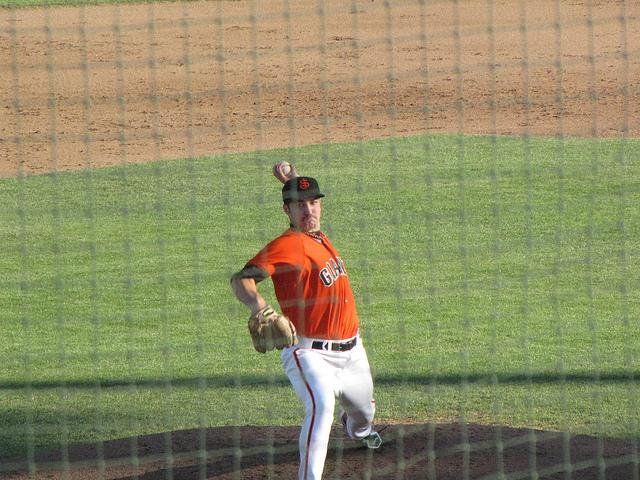

In [5]:
print(ds[1]["text"])
ds[1]["image"]

In [6]:
from seahorse.data.collator import SeahorseDataCollator

# Try to run a single batch through the data collator
sample_batch1 = [ds[i] for i in range(min(2, len(ds)))]
collator = SeahorseDataCollator(model=seahorse)
try:
    processed_batch1 = collator(sample_batch1)
    print("Batch processed successfully")
    for k, v in processed_batch1.items():
        print(f"{k}: {v.shape}")
except Exception as e:
    print(f"Error processing batch: {str(e)}")

# del sample_batch1, processed_batch1

Batch processed successfully
pixel_values: torch.Size([2, 3, 224, 224])
input_ids: torch.Size([2, 40])
attention_mask: torch.Size([2, 40])
labels: torch.Size([2, 40])


In [7]:
if True:
    image_patches = seahorse.encode_and_project_image(processed_batch1["pixel_values"].to(device, dtype))
    text_embeds = seahorse.get_input_embeddings()(processed_batch1["input_ids"].to(device))
    output_embeds, new_attention_mask, new_output_labels, pos_ids = seahorse.merge_text_and_image_tokens(
        input_ids=processed_batch1["input_ids"].to(device),
        text_embeds=text_embeds,
        image_patch_embeds=image_patches,
        attention_mask=processed_batch1["attention_mask"].to(device),
        text_labels=processed_batch1["labels"].to(device)
    )

In [12]:
# Generate a mapping from decoded input_id to label for an individual example in processed_batch1
idx_in_batch = 0
for input_ids, labels in zip(processed_batch1["input_ids"][idx_in_batch], processed_batch1["labels"][idx_in_batch]):
    decoded_input_id = seahorse.tokenizer.decode(input_ids, skip_special_tokens=False)
    print("|", decoded_input_id, "\tlabel:", labels.item())

| <pad> 	label: -100
| <pad> 	label: -100
| <pad> 	label: -100
| <pad> 	label: -100
| <pad> 	label: -100
| <pad> 	label: -100
| <pad> 	label: -100
| <|system|> 	label: 32006
| Give 	label: 25538
| a 	label: 263
| short 	label: 3273
| answer 	label: 1234
| directly 	label: 4153
| . 	label: 29889
| <|end|> 	label: 32007
| <|user|> 	label: 32010
| <image> 	label: 32012
|  	label: 29871
| 
 	label: 13
| What 	label: 5618
| is 	label: 338
| this 	label: 445
| photo 	label: 15373
| taken 	label: 4586
| looking 	label: 3063
| through 	label: 1549
| ? 	label: 29973
| 
 	label: 13
| Con 	label: 1168
| c 	label: 29883
| ise 	label: 895
| answer 	label: 1234
| only 	label: 871
| . 	label: 29889
| <|end|> 	label: 32007
| <|assistant|> 	label: 32001
| Net 	label: 12670
| . 	label: 29889
| <|end|> 	label: 32007
| <|endoftext|> 	label: 32000


In [ ]:
processed_batch1["input_ids"]

tensor([[32000, 32000, 32000, 32006,   673,   278,  1139,   773,   263,  2323,
          1734,   470, 16549, 29889, 32007, 32010, 32011, 29871,    13,  5618,
           338,   445, 15373,  4586,  3063,  1549, 29973,    13,  1168, 29883,
           895,  1234,   871, 29889, 32007, 32001, 12670, 29889, 32007, 32000],
        [32000, 32000, 32000, 32006,   673,   278,  1139,   773,   263,  2323,
          1734,   470, 16549, 29889, 32007, 32010, 32011, 29871,    13,  5618,
          2602,   338,   445,   767,  8743, 29973,    13,  9598,  1022,   372,
         11473, 29889, 32007, 32001,   349,  2335,   261, 29889, 32007, 32000]])

In [19]:
processed_batch1["attention_mask"]

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [20]:
from seahorse.experiments.experiment_utils import print_gpu_memory_usage
from seahorse.experiments.experiment_utils import enable_transformers_logging

enable_transformers_logging()
print_gpu_memory_usage()

GPU memory usage: 7.74GB


In [15]:
# IDEAS TODO:
## Llava pretraines only the projector (frozen llm and vision tower)

In [17]:

from seahorse.train.seahorse_trainer import SeahorseTrainer
from seahorse.experiments.experiment_utils import generate_two_word_name

run_config.training_arguments.run_name = generate_two_word_name()
trainer = SeahorseTrainer(
    model=seahorse,
    args=run_config.training_arguments,
    train_dataset=ds,
    data_collator=SeahorseDataCollator(model=seahorse),
)
trainer.train()

/home/tromero/miniforge3/envs/seahorse2/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices


Using auto half precision backend


Run name: flourishing-cloud


***** Running training *****
  Num examples = 82,772
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2,587
  Number of trainable parameters = 221,386,752
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
10,7.546800
20,4.265300
30,1.581300
40,1.121300
50,1.136200
60,1.147900
70,1.268300
80,1.238800
90,1.177900
100,1.183800


KeyboardInterrupt: 

In [ ]:
# from transformers.integrations import WandbCallback
# import pandas as pd


# def decode_predictions(tokenizer, predictions):
#     labels = tokenizer.batch_decode(predictions.label_ids)
#     logits = predictions.predictions.argmax(axis=-1)
#     prediction_text = tokenizer.batch_decode(logits)
#     return {"labels": labels, "predictions": prediction_text}


# class WandbPredictionProgressCallback(WandbCallback):
#     """Custom WandbCallback to log model predictions during training.

#     This callback logs model predictions and labels to a wandb.Table at each
#     logging step during training. It allows to visualize the
#     model predictions as the training progresses.

#     Attributes:
#         trainer (Trainer): The Hugging Face Trainer instance.
#         tokenizer (AutoTokenizer): The tokenizer associated with the model.
#         sample_dataset (Dataset): A subset of the validation dataset
#           for generating predictions.
#         num_samples (int, optional): Number of samples to select from
#           the validation dataset for generating predictions. Defaults to 100.
#         freq (int, optional): Frequency of logging. Defaults to 2.
#     """

#     def __init__(self, trainer, tokenizer, val_dataset,
#                  num_samples=100, freq=2):
#         """Initializes the WandbPredictionProgressCallback instance.

#         Args:
#             trainer (Trainer): The Hugging Face Trainer instance.
#             tokenizer (AutoTokenizer): The tokenizer associated
#               with the model.
#             val_dataset (Dataset): The validation dataset.
#             num_samples (int, optional): Number of samples to select from
#               the validation dataset for generating predictions.
#               Defaults to 100.
#             freq (int, optional): Frequency of logging. Defaults to 2.
#         """
#         super().__init__()
#         self.trainer = trainer
#         self.tokenizer = tokenizer
#         self.sample_dataset = val_dataset.select(range(num_samples))
#         self.freq = freq

#     def on_evaluate(self, args, state, control, **kwargs):
#         super().on_evaluate(args, state, control, **kwargs)
#         # control the frequency of logging by logging the predictions
#         # every `freq` epochs
#         if state.epoch % self.freq == 0:
#             # generate predictions
#             predictions = self.trainer.predict(self.sample_dataset)
#             # decode predictions and labels
#             predictions = decode_predictions(self.tokenizer, predictions)
#             # add predictions to a wandb.Table
#             predictions_df = pd.DataFrame(predictions)
#             predictions_df["epoch"] = state.epoch
#             records_table = self._wandb.Table(dataframe=predictions_df)
#             # log the table to wandb
#             self._wandb.log({"sample_predictions": records_table})
